# Monetary Economics: Chapter 3, Model SIMEX

In [1]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline

import matplotlib.pyplot as plt

from pysolve.model import Model
from pysolve.utils import is_close, round_solution


In [2]:
def create_simex_model():
    model = Model()

    model.set_var_default(0)
    model.var('Cd', desc='Consumption goods demand by households')
    model.var('Cs', desc='Consumption goods supply')
    model.var('Gs', desc='Government goods, supply')
    model.var('Hd', desc='Cash money demanded by households')
    model.var('Hh', desc='Cash money held by households')
    model.var('Hs', desc='Cash money supplied by the government')
    model.var('Nd', desc='Demand for labor')
    model.var('Ns', desc='Supply of labor')
    model.var('Td', desc='Taxes, demand')
    model.var('Ts', desc='Taxes, supply')
    model.var('Y', desc='Income = GDP')
    model.var('YD', desc='Disposable income of households')
    model.var('YDe', desc='Expected disposable income')

    model.set_param_default(0)
    model.param('Gd', desc='Government goods, demand')
    model.param('W', desc='Wage rate')
    model.param('alpha1', desc='Propensity to consume out of income')
    model.param('alpha2', desc='Propensity to consume o of wealth')
    model.param('theta', desc='Tax rate')

    model.add('Cs = Cd')  # 3.1
    model.add('Gs = Gd')  # 3.2
    model.add('Ts = Td')  # 3.3
    model.add('Ns = Nd')  # 3.4
    model.add('YD = (W*Ns) - Ts') # 3.5
    model.add('Td = theta * W * Ns')  # 3.6, theta < 1.0
    model.add('Cd = alpha1*YDe + alpha2*Hh(-1)') # 3.7E, 0 < alpha2 < alpha1 < 1
    model.add('Hs - Hs(-1) =  Gd - Td')  # 3.8
    model.add('Hh - Hh(-1) = YD - Cd') # 3.9
    model.add('Hd - Hs(-1) = YDe - Cd') # 3.18
    model.add('Y = Cs + Gs') # 3.10
    model.add('Nd = Y/W') # 3.11
    model.add('YDe = YD(-1)')  # 3.20
        
    return model


### Steady state solution

In [3]:
steady_state = create_simex_model()
steady_state.set_values({'alpha1': 0.6,
                         'alpha2': 0.4,
                         'theta': 0.2,
                         'Gd': 20,
                         'W': 1})

# Set the value so that YD(-1) gets calculated correctly
steady_state.variables['YD'].value = steady_state.evaluate('Gd*(1-theta)')
steady_state.variables['YD'].default = steady_state.evaluate('Gd*(1-theta)')

for _ in range(100):
    steady_state.solve(iterations=100, threshold=1e-5)

    if is_close(steady_state.solutions[-2], steady_state.solutions[-1], atol=1e-4):
        break

In [4]:
from IPython.display import HTML
import numpy
from pysolve.utils import generate_html_table

data = list()
for var in [('Gd', 'G'), ('Y', 'Y'), ('Ts', 'T'), ('YD', 'YD'), 
            ('YDe', 'YDe'), ('Cs', 'C')]:
    rowdata = list()
    rowdata.append(var[1])
    for i in [0, 1, 2, -1]:
        rowdata.append(str(numpy.round(steady_state.solutions[i][var[0]], decimals=1)))
    data.append(rowdata)

for var in [('Hs', '&Delta;Hs'), ('Hh', '&Delta;Hh')]:
    rowdata = list()
    rowdata.append(var[1])
    rowdata.append(str(numpy.round(steady_state.solutions[0][var[0]], decimals=1)))
    for i in [1, 2, -1]:
        rowdata.append(str(numpy.round(steady_state.solutions[i][var[0]] - 
                                       steady_state.solutions[i-1][var[0]], decimals=1)))
    data.append(rowdata)

for var in [('Hh', 'H')]:
    rowdata = list()
    rowdata.append(var[1])
    for i in [0, 1, 2, -1]:
        rowdata.append(str(numpy.round(steady_state.solutions[i][var[0]], decimals=1)))
    data.append(rowdata)

for var in [('Hd', '&Delta;Hd')]:
    rowdata = list()
    rowdata.append(var[1])
    rowdata.append(str(numpy.round(steady_state.solutions[0][var[0]], decimals=1)))
    for i in [1, 2, -1]:
        rowdata.append(str(numpy.round(steady_state.solutions[i][var[0]] - 
                                       steady_state.solutions[i-1][var[0]], decimals=1)))
    data.append(rowdata)

for var in [('Hd', 'Hd')]:
    rowdata = list()
    rowdata.append(var[1])
    for i in [0, 1, 2, -1]:
        rowdata.append(str(numpy.round(steady_state.solutions[i][var[0]], decimals=1)))
    data.append(rowdata)

s = generate_html_table(['Period', '1', '2', '3', '&infin;'], data)
HTML(s)

Period,1,2,3,∞
G,20.0,20.0,20.0,20.0
Y,0.0,29.6,39.8,100.0
T,0.0,5.9,8.0,20.0
YD,16.0,23.7,31.9,80.0
YDe,0.0,16.0,23.7,80.0
C,0.0,9.6,19.8,80.0
ΔHs,0.0,14.1,12.0,0.0
ΔHh,0.0,14.1,12.0,0.0
H,0.0,14.1,26.1,80.0
ΔHd,0.0,6.4,11.5,0.0


###### Figure 3.5

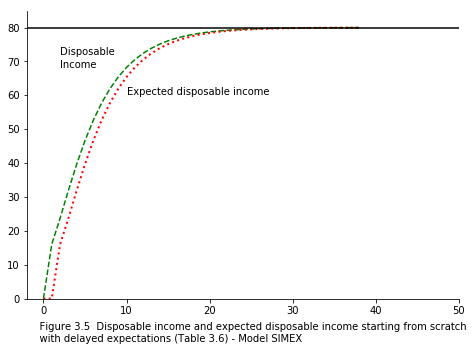

In [5]:
caption = '''
    Figure 3.5  Disposable income and expected disposable income starting from scratch
    with delayed expectations (Table 3.6) - Model SIMEX '''

# Add an extra iteration to show YDe starting from zero
yddata = [0] + [s['YD'] for s in steady_state.solutions]
ydedata = [0] + [s['YDe'] for s in steady_state.solutions]

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1.0, 1.0])
axes.tick_params(top=False, right=False)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_ylim(0, 85)
axes.set_xlim(-2, 50)

axes.plot(yddata, linestyle='--', color='g')  # plot YD
axes.plot(ydedata, linestyle=':', linewidth=2, color='r')  # plot YDe
plt.axhline(y=80, color='k')

# add labels
plt.text(2, 72, 'Disposable')
plt.text(2, 68, 'Income')
plt.text(10, 60, 'Expected disposable income')

fig.text(0.1, -0.05, caption);


### Model with fixed expected disposable income

Create the model with fixed YDe.

In [6]:
def create_simex_yde_model():
    model = Model()

    model.set_var_default(0)
    model.var('Cd', desc='Consumption goods demand by households')
    model.var('Cs', desc='Consumption goods supply')
    model.var('Gs', desc='Government goods, supply')
    model.var('Hd', desc='Cash money demanded by households')
    model.var('Hh', desc='Cash money held by households')
    model.var('Hs', desc='Cash money supplied by the government')
    model.var('Nd', desc='Demand for labor')
    model.var('Ns', desc='Supply of labor')
    model.var('Td', desc='Taxes, demand')
    model.var('Ts', desc='Taxes, supply')
    model.var('Y', desc='Income = GDP')
    model.var('YD', desc='Disposable income of households')
    model.var('YDe', desc='Expected disposable income')

    model.param('Gd', desc='Government goods, demand')
    model.param('W', desc='Wage rate')
    model.param('YDstar', desc='Exogenously fixed expected disposable income')
    model.param('alpha1', desc='Propensity to consume out of income')
    model.param('alpha2', desc='Propensity to consume o of wealth')
    model.param('theta', desc='Tax rate')

    model.add('Cs = Cd')  # 3.1
    model.add('Gs = Gd')  # 3.2
    model.add('Ts = Td')  # 3.3
    model.add('Ns = Nd')  # 3.4
    model.add('YD = (W*Ns) - Ts') # 3.5
    model.add('Td = theta * W * Ns')  # 3.6, theta < 1.0
    model.add('Cd = alpha1*YDe + alpha2*Hh(-1)') # 3.7E, 0 < alpha2 < alpha1 < 1
    model.add('Hs - Hs(-1) =  Gd - Td')  # 3.8
    model.add('Hh - Hh(-1) = YD - Cd') # 3.9
    model.add('Hd - Hs(-1) = YDe - Cd') # 3.18
    model.add('Y = Cs + Gs') # 3.10
    model.add('Nd = Y/W') # 3.11
    model.add('YDe = YDstar')  # 3.20
        
    return model


In [7]:
# Use the steady state solution as a starting point
step_model = create_simex_yde_model()

step_model.set_values({'Gd': 20,
                       'W': 1,
                       'YDstar': 80,
                       'alpha1': 0.6,
                       'alpha2': 0.4,
                       'theta': 0.2})

# start from the steady-state equilibrium
step_model.set_values({'YD': 80,
                       'YDe': 80,
                       'Cd': 80,
                       'Cs': 80,
                       'Gs': 20,
                       'Y': 100,
                       'Nd': 100,
                       'Ns': 100,
                       'Td': 20,
                       'Ts': 20,
                       'Hh': 80,
                       'Hs': 80,
                       'Hd': 80,
                       'YD': 'Gd*(1-theta)'})

for i in range(40):
    step_model.solve(iterations=100, threshold=1e-5)
    if i == 2:
        step_model.parameters['Gd'].value += 5

###### Figure 3.6

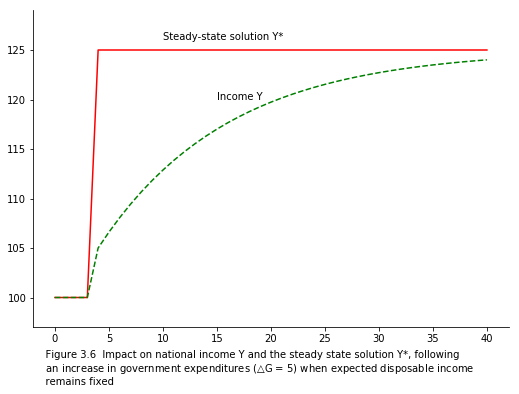

In [8]:
caption = '''
    Figure 3.6  Impact on national income Y and the steady state solution Y*, following
    an increase in government expenditures ($\\bigtriangleup$G = 5) when expected disposable income
    remains fixed'''
    
gdata = [s['Gd']/s['theta'] for s in step_model.solutions]
ydata = [s['Y'] for s in step_model.solutions]

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1.1, 1.1])
axes.tick_params(top=False, right=False)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_ylim(97, 129)

axes.plot(gdata, 'r')  # plot G/theta
axes.plot(ydata, linestyle='--', color='g')  # plot Y

# add labels
plt.text(10, 126, 'Steady-state solution Y*')
plt.text(15, 120, 'Income Y')
fig.text(0.1, -0.1, caption);


###### Figure 3.7

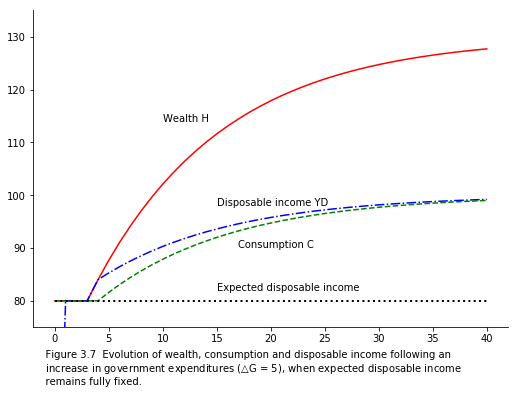

In [9]:
caption = '''
    Figure 3.7  Evolution of wealth, consumption and disposable income following an
    increase in government expenditures ($\\bigtriangleup$G = 5), when expected disposable income
    remains fully fixed.'''
hdata = [s['Hh'] for s in step_model.solutions]
yddata = [s['YD'] for s in step_model.solutions]
cdata = [s['Cd'] for s in step_model.solutions]
ydedata = [s['YDe'] for s in step_model.solutions]

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1.1, 1.1])
axes.tick_params(top=False, right=False)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_ylim(75, 135)

axes.plot(hdata, color='r')  # plot H
axes.plot(yddata, linestyle='-.', color='b')  # plot YD
axes.plot(cdata, linestyle='--', color='g')  # plot C
axes.plot(ydedata, linestyle=':', linewidth=2, color='k')  # plot YDe

# add labels
plt.text(10, 114, 'Wealth H')
plt.text(15, 98, 'Disposable income YD')
plt.text(17, 90, 'Consumption C')
plt.text(15, 82, 'Expected disposable income')
fig.text(0.1, -.1, caption);
